# Steady Flow, Single Layer Aquifer

This section is a worked example using `FLOPY` and `MODFLOW6` installed on a `aarch-64` computer.  `x86-...` architectures should use the `! get-modflow` method to download (in near real time) current binaries

### Obleo Aquifer Example

This is a steady-state model of the Obleo aquifer system depicted below:

![](obleoaquifer.png)

Sone added information about the system is:

![](obleoparticulars.png)

The general goals for the analysis are:

![](obleogoals.png)

So with a little infomration regarding how we will manage elevations we can move forward with the modeling effort.

![](obleovertdatum.png)

Now onto **modflow**

:::{warning}
Nearly every cell throws a deprecation warning, that filterwarnings('ignore') fails to suppress.  Code seems to still run on my server, but over time as new updates are added to the kernel the code at some point will fail without addressing the warning.  The development computer is `aarch64` an arm processor.  The AWS server is `amd64/intel` architecture, which gets a lot of code development so should stay current longer.  This continuous integration CI and push changes model of modern IT support is phenomenally annoying, but for time being have to get used to it.
:::

In [39]:
%reset -f

In [40]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [41]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [42]:
# Workspace and Executibles
binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/example_2" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name
name = "example02_obleo"

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

In [43]:
# Set Time Structure
Time_Units="YEARS"

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=1, perioddata=[(1.0, 1, 1.0)]
)

In [44]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [45]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [46]:

# Define The Grid
Nlay = 1 #number layers
Nrow = 11 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 100.0 # elevation of top of aquifer
thick = 1000.0 #aquifer thickness

bot = [topelev-thick] # bot is a list with Nlay entries
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


In [47]:
# Define initial conditions
h1 = 0.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [48]:
# Define hydraulic conductivity arrays
K = 3650.0
k = K * np.ones((Nlay, Nrow, Ncol)) # Hydraulic conductivity is K everywhere
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky


##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

In [49]:
# Define constant head boundary conditions
chd_rec = []
#h2 = 90 # Just a different value 
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
for layer in range(0, Nlay):
    for row in range(0, Nrow):
        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=chd_rec,save_flows=True,
)

In [50]:
# Define wellfields
wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr

##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=len(wel_rec),stress_period_data=wel_rec,
)

In [51]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=rech_rec)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

In [52]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


In [53]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [54]:
# Write files to the directory
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model example02_obleo...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [55]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: /home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

         MODFLOW 6 compiled Apr 16 2023 18:27:14 with GCC version 9.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Als

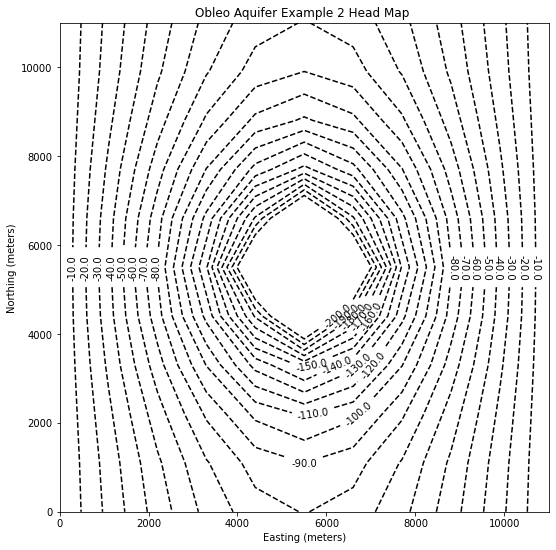

In [56]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 0., 10.)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

Now for pretty mapping!

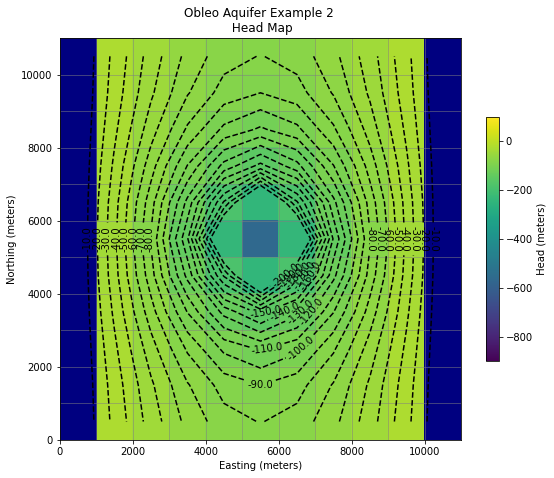

In [57]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

So this seems like a working model next we need to see if the heads are no less than -650 meters (the minimum allowed saturated thickness).  We already have this information contained in the output object.

In [58]:
print("Minimum allowed is -650.0 meters")
print("Pumping at P-1 is:",wel_rec[0][3]/1e6," Mm^3/yr")
print("Minimum Head is:",round(h[0].min(),1)," meters")
if h[0].min() < -650.0:
    print("Computed head is below allowed value - reduce pumpage and rerun simulation")

Minimum allowed is -650.0 meters
Pumping at P-1 is: -2114.0  Mm^3/yr
Minimum Head is: -563.4  meters
